# Introduction

Home Credit is a non-banking financial institution, founded in 1997 in the Czech Republic.

The company operates in 14 countries (including United States, Russia, Kazahstan, Belarus, China, India) and focuses on lending primarily to people with little or no credit history which will either not obtain loans or became victims of untrustworthly lenders.

Home Credit group has over 29 million customers, total assests of 21 billions Euro, over 160 millions loans.

The company uses of a variety of alternative data - including telco and transactional information - to predict their clients' repayment abilities.

The goal of this competition is to help them unlock the full potential of their data. 

This afternoon, every team need to submit their prediction on the Kaggle and get a feedback of the Leaderboard rank and AUC score. Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target. For each SK_ID_CURR in the test set, you must predict a probability for the TARGET variable. The file should contain a header and have the following format: 
```
SK_ID_CURR,TARGET
100001,0.1
100005,0.9
100013,0.2
etc.
```

# Load the data

You can download the data from Kaggle:https://www.kaggle.com/c/home-credit-default-risk

Since there are so many features in each tables, I made these data summaries for your quick check:

- Main table: http://nbviewer.jupyter.org/github/gukun770/Home-Credit/blob/master/data_summary_application_train.ipynb
- Other tables: http://nbviewer.jupyter.org/github/gukun770/Home-Credit/blob/master/data_summary_others.ipynb

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as scs

%matplotlib inline
plt.style.use('ggplot') # overall 'ggplot' style

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina') 

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_curve
from sklearn.preprocessing import PolynomialFeatures, Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold

In [3]:
pd.set_option("display.max_colwidth",999)
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

Helper function ```col_name(name, df_description)```--> gives description of the column name defined in the table HomeCredit_columns_description.csv

In [4]:
col_description = pd.read_csv('data/HomeCredit_columns_description.csv',
                              index_col=0,encoding='cp1252')

def col_name(name, col_description=col_description):
    values = col_description[col_description['Row'] == name]['Description'].values
    print(name + ': \n')
    for i in values:
        print (i+'\n')
    table = col_description[col_description['Row'] == name]['Table'].values
    print('Table: {}\n'.format(table))

In [5]:
col_name('TARGET')

TARGET: 

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

Table: ['application_{train|test}.csv']



In [6]:
def plot_data(col_name, df, numeric=True):
    if numeric:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
        sns.boxplot(df[col_name], ax=ax1);
        sns.distplot(df[col_name].dropna(), ax=ax2);
        plt.show();
    else:
        plt.figure(figsize=(10,4))
        sns.countplot(x=col_name, data=df, orient='h',
                      order = df[col_name].value_counts().index, alpha=.7)
        plt.show()

In [7]:
application_train = pd.read_csv('data/application_train.csv.zip') 
application_test = pd.read_csv('data/application_test.csv.zip') 

- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in the data sample.
- This week we'll be mainly focused on this table.

In [8]:
print("application_train -  rows:",application_train.shape[0],
      " columns:", application_train.shape[1])
print("application_test -  rows:",application_test.shape[0],
      " columns:", application_test.shape[1])

application_train -  rows: 307511  columns: 122
application_test -  rows: 48744  columns: 121


In [10]:
df_all_dummies = pd.get_dummies(application_train)
df_corr = df_all_dummies.corr()

In [11]:
def show_corr(col_name,df_corr=df_corr, df=application_train, nb=6):
    
    if application_train.dtypes[col_name] == 'object':
        names = df[col_name].unique()
        names = ['{}_{}'.format(col_name, i) for i in names if i is not np.nan]
        for name in names:
            corr_table = pd.DataFrame({'Most positive corr column':df_corr[name].sort_values(ascending=False)[:nb].index,
                                   'Most positive corr value':df_corr[name].sort_values(ascending=False)[:nb].values,
                                   'Most negative corr column': df_corr[name].sort_values(ascending=True)[:nb].index,
                                   'Most negative corr value': df_corr[name].sort_values(ascending=True)[:nb].values})
            print(name)
            print(corr_table)
            print('\n')
            
    else:
        corr_table = pd.DataFrame({'Most positive corr column':df_corr[col_name].sort_values(ascending=False)[:nb].index,
                                   'Most positive corr value':df_corr[col_name].sort_values(ascending=False)[:nb].values,
                                   'Most negative corr column': df_corr[col_name].sort_values(ascending=True)[:nb].index,
                                   'Most negative corr value': df_corr[col_name].sort_values(ascending=True)[:nb].values})
        return corr_table

In [12]:
show_corr('TARGET')

,Most negative corr column,Most negative corr value,Most positive corr column,Most positive corr value
0,EXT_SOURCE_3,-0.178919,TARGET,1.000000
1,EXT_SOURCE_2,-0.160472,DAYS_BIRTH,0.078239
2,EXT_SOURCE_1,-0.155317,REGION_RATING_CLIENT_W_CITY,0.060893
3,NAME_EDUCATION_TYPE_Higher education,-0.056593,REGION_RATING_CLIENT,0.058899
4,CODE_GENDER_F,-0.054704,NAME_INCOME_TYPE_Working,0.057481
5,NAME_INCOME_TYPE_Pensioner,-0.046209,DAYS_LAST_PHONE_CHANGE,0.055218


In [13]:
# checking missing data
total = application_train.isnull().sum().sort_values(ascending = False)
percent = (application_train.isnull().sum()/application_train.isnull().count()*100).sort_values(ascending = False)
missing_application_train_data  = pd.concat([total, percent], axis=1,
                                            keys=['Total', 'Percent'])
missing_application_train_data.head(20)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


## TARGET 

In [14]:
col_name('TARGET')

TARGET: 

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

Table: ['application_{train|test}.csv']



In [15]:
pct = application_train["TARGET"].value_counts(1)
cnt = application_train["TARGET"].value_counts()
cnt_table = pd.concat([pct, cnt], axis=1, keys=['Percent', 'Total'])
cnt_table

,Percent,Total
0,0.919271,282686
1,0.080729,24825


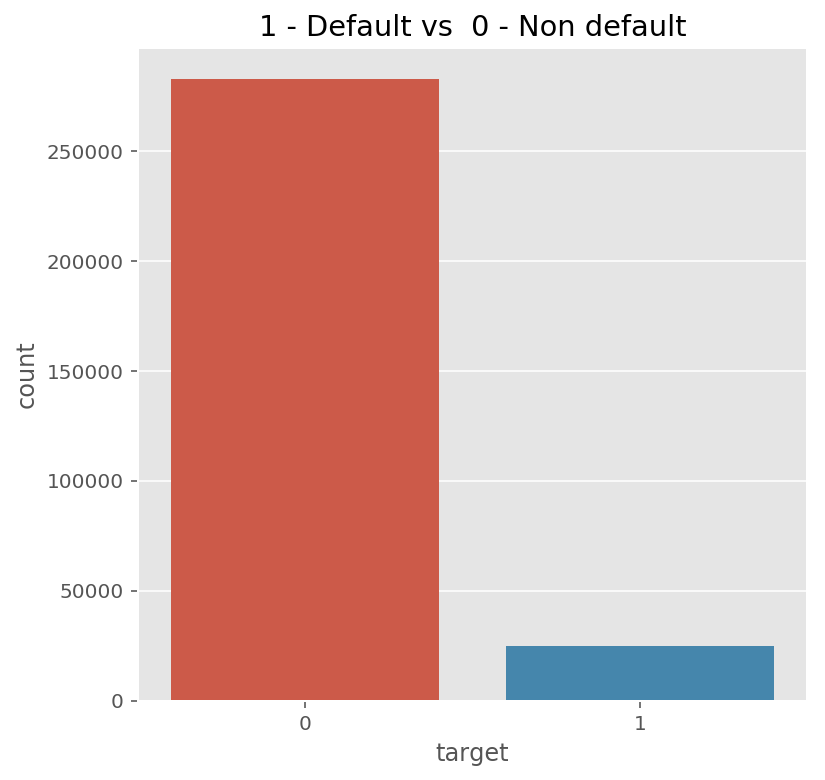

In [16]:
target = application_train["TARGET"].value_counts()
df = pd.DataFrame({'target': target.index,
                   'count': target.values
                  })
plt.figure(figsize = (6,6))
plt.title('1 - Default vs  0 - Non default')
sns.barplot(x = 'target', y="count", data=df);

We can see that the target is very imbalanced. There are far more loans repaid on time than loans that were not repaid on time. 

## Feature Engineering

Try some interaction terms between features by multiplying/dividing each others.

```
top idea:
obs_30 or obs_60
AMT_CREDIT / AMT_INCOME_TOTAL
Fam size vs cnt chidren
own realty
own car
nice to have:
amt_req_redit_buro
housing type
```

In [17]:
# show_corr('CODE_GENDER')

In [18]:
temp_n = application_train[application_train.FLAG_OWN_REALTY=='N']
a = temp_n.TARGET
b = temp_n.FLAG_OWN_REALTY
c = temp_n.WALLSMATERIAL_MODE

wall_n = pd.crosstab(a,c,rownames=['Default?'],
            colnames=['Wall material']).T.apply(lambda r: r/r.sum(), axis=0)
wall_n['1-0']=wall_n[1]-wall_n[0]
print('Lessee')
wall_n

Lessee


Default?,0,1,1-0
Wall material,,,
Block,0.063188,0.062363,-0.000825
Mixed,0.014983,0.015982,0.001000
Monolithic,0.012401,0.006894,-0.005507
Others,0.010929,0.011595,0.000666
Panel,0.436861,0.393920,-0.042940
"Stone, brick",0.419900,0.451896,0.031996
Wooden,0.041739,0.057349,0.015610


In [19]:
temp_y = application_train[application_train.FLAG_OWN_REALTY=='Y']
a = temp_y.TARGET
b = temp_y.FLAG_OWN_REALTY
c = temp_y.WALLSMATERIAL_MODE

wall_y = pd.crosstab(a,c,rownames=['Default?'],
            colnames=['Wall material']).T.apply(lambda r: r/r.sum(), axis=0)
wall_y['1-0']=wall_y[1]-wall_y[0]
print('Realty owner')
wall_y

Realty owner


Default?,0,1,1-0
Wall material,,,
Block,0.060342,0.061252,0.000910
Mixed,0.015146,0.016569,0.001423
Monolithic,0.011909,0.008420,-0.003489
Others,0.010457,0.013310,0.002853
Panel,0.441080,0.398615,-0.042465
"Stone, brick",0.429685,0.456064,0.026379
Wooden,0.031381,0.045769,0.014388


In [20]:
application_train.groupby("WALLSMATERIAL_MODE").mean()['AMT_INCOME_TOTAL'].sort_values(ascending=False)

WALLSMATERIAL_MODE
Monolithic      243048.371838
Mixed           185609.543127
Block           184543.414568
Panel           183648.758309
Others          181440.384923
Stone, brick    176379.581750
Wooden          162801.834204
Name: AMT_INCOME_TOTAL, dtype: float64

In [21]:
pd.crosstab(application_train.NAME_INCOME_TYPE,application_train.TARGET).apply(lambda r: r/r.sum(), axis=0)

TARGET,0,1
NAME_INCOME_TYPE,,
Businessman,0.000035,0.000000
Commercial associate,0.234384,0.215911
Maternity leave,0.000011,0.000081
Pensioner,0.185294,0.120121
State servant,0.072356,0.050312
Student,0.000064,0.000000
Unemployed,0.000050,0.000322
Working,0.507807,0.613253


In [22]:
application_train.groupby(['NAME_INCOME_TYPE'])['AMT_INCOME_TOTAL'].mean().sort_values(ascending=False)

NAME_INCOME_TYPE
Businessman             652500.000000
Commercial associate    202955.327289
State servant           179737.969506
Student                 170500.000000
Working                 163169.889223
Maternity leave         140400.000000
Pensioner               136401.292273
Unemployed              110536.363636
Name: AMT_INCOME_TOTAL, dtype: float64

In [23]:
application_train.groupby(['NAME_INCOME_TYPE','WALLSMATERIAL_MODE'])[['AMT_INCOME_TOTAL']].mean().unstack().round(0)

AMT_INCOME_TOTAL                                 \
WALLSMATERIAL_MODE              Block     Mixed Monolithic    Others   
NAME_INCOME_TYPE                                                       
Businessman                  900000.0       NaN        NaN       NaN   
Commercial associate         227809.0  224567.0   288274.0  203639.0   
Maternity leave                   NaN       NaN        NaN       NaN   
Pensioner                    144609.0  145030.0   178409.0  149884.0   
State servant                198714.0  201340.0   239782.0  201132.0   
Student                           NaN       NaN        NaN       NaN   
Unemployed                   225000.0       NaN        NaN       NaN   
Working                      171277.0  174499.0   219123.0  173536.0   

                                                       
WALLSMATERIAL_MODE       Panel Stone, brick    Wooden  
NAME_INCOME_TYPE                                       
Businessman           461250.0    1125000.0       NaN  
Commercial associate  216162.0     206549.0  187270.0  
Maternity leave       360000.0     135000.0       NaN  
Pensioner             148360.0     141217.0  127083.0  
State servant         199305.0     186499.0  191723.0  
Student               183375.0     216000.0       NaN  
Unemployed            121500.0      78750.0       NaN  
Working               176384.0     172149.0  160547.0

In [24]:
pd.crosstab(application_train.NAME_EDUCATION_TYPE,application_train.TARGET).apply(
    lambda r: r/r.sum(), axis=0)

TARGET,0,1
NAME_EDUCATION_TYPE,,
Academic degree,0.000570,0.000121
Higher education,0.250646,0.161490
Incomplete higher,0.033270,0.035126
Lower secondary,0.012024,0.016798
Secondary / secondary special,0.703491,0.786465


### Gender

In [25]:
pd.crosstab(application_train.CODE_GENDER, application_train.TARGET).apply(lambda r: r/r.sum(), axis=0)

TARGET,0,1
CODE_GENDER,,
F,0.666032,0.570796
M,0.333954,0.429204
XNA,0.000014,0.000000


### Job difference

In [26]:
temp = pd.crosstab(application_train.OCCUPATION_TYPE, application_train.TARGET).apply(
    lambda r: r/r.sum(), axis=0)
temp['1-0'] = temp[1]-temp[0]
temp

TARGET,0,1,1-0
OCCUPATION_TYPE,,,
Accountants,0.048496,0.025557,-0.022939
Cleaning staff,0.021841,0.024101,0.002260
Cooking staff,0.027652,0.033483,0.005831
Core staff,0.134141,0.093708,-0.040433
Drivers,0.085661,0.113603,0.027942
HR staff,0.002737,0.001941,-0.000796
High skill tech staff,0.055454,0.037796,-0.017658
IT staff,0.002555,0.001833,-0.000722
Laborers,0.256256,0.314768,0.058512


In [27]:
(temp.loc[(temp['1-0']>0.002) | (temp['1-0']<-0.002),:]*100).round(1).sort_values(by='1-0')

TARGET,0,1,1-0
OCCUPATION_TYPE,,,
Core staff,13.4,9.4,-4.0
Managers,10.4,7.2,-3.2
Accountants,4.8,2.6,-2.3
High skill tech staff,5.5,3.8,-1.8
Medicine staff,4.1,3.1,-1.1
Private service staff,1.3,0.9,-0.3
Cleaning staff,2.2,2.4,0.2
Cooking staff,2.8,3.3,0.6
Security staff,3.1,3.9,0.8


In [28]:
jobs = temp.loc[(temp['1-0']>0.002) | (temp['1-0']<-0.002),:].index

In [29]:
# show_corr('OCCUPATION_TYPE', nb=3)

### Age

In [ ]:
# pd.crosstab(application_train.DAYS_EMPLOYED,
#             application_train.TARGET).apply(lambda r:r/r.sum(),axis=1)

### Asset - Car

In [31]:
show_corr('FLAG_OWN_CAR')

FLAG_OWN_CAR_N
  Most negative corr column  Most negative corr value  \
0            FLAG_OWN_CAR_Y                 -1.000000   
1             CODE_GENDER_M                 -0.345841   
2           FLAG_DOCUMENT_8                 -0.228368   
3   OCCUPATION_TYPE_Drivers                 -0.186404   
4            FLAG_EMP_PHONE                 -0.154659   
5           CNT_FAM_MEMBERS                 -0.149901   

    Most positive corr column  Most positive corr value  
0              FLAG_OWN_CAR_N                  1.000000  
1               CODE_GENDER_F                  0.345847  
2  NAME_INCOME_TYPE_Pensioner                  0.154826  
3       ORGANIZATION_TYPE_XNA                  0.154778  
4               DAYS_EMPLOYED                  0.154441  
5    NAME_FAMILY_STATUS_Widow                  0.114885  


FLAG_OWN_CAR_Y
    Most negative corr column  Most negative corr value  \
0              FLAG_OWN_CAR_N                 -1.000000   
1               CODE_GENDER_F               

In [32]:
temp = application_train.copy()

In [33]:
pd.crosstab(application_train.FLAG_OWN_CAR, application_train.TARGET).apply(lambda r:r/r.sum(),axis=1)

TARGET,0,1
FLAG_OWN_CAR,,
N,0.914998,0.085002
Y,0.927563,0.072437


In [35]:
pd.crosstab(application_train.OWN_CAR_AGE,
            application_train.TARGET).apply(lambda r:r/r.sum(),axis=1).head()

TARGET,0,1
OWN_CAR_AGE,,
0.0,0.931115,0.068885
1.0,0.936364,0.063636
2.0,0.940021,0.059979
3.0,0.950078,0.049922
4.0,0.946014,0.053986


In [36]:
temp['car_condition']= pd.cut(application_train.OWN_CAR_AGE,
                              bins=[0,3,10,20,100], labels=['new','average','old','very old'])                         

In [37]:
pd.crosstab(temp.car_condition,
            application_train.TARGET).apply(lambda r:r/r.sum(),axis=1)

TARGET,0,1
car_condition,,
new,0.942578,0.057422
average,0.938714,0.061286
old,0.914542,0.085458
very old,0.906925,0.093075


### Income

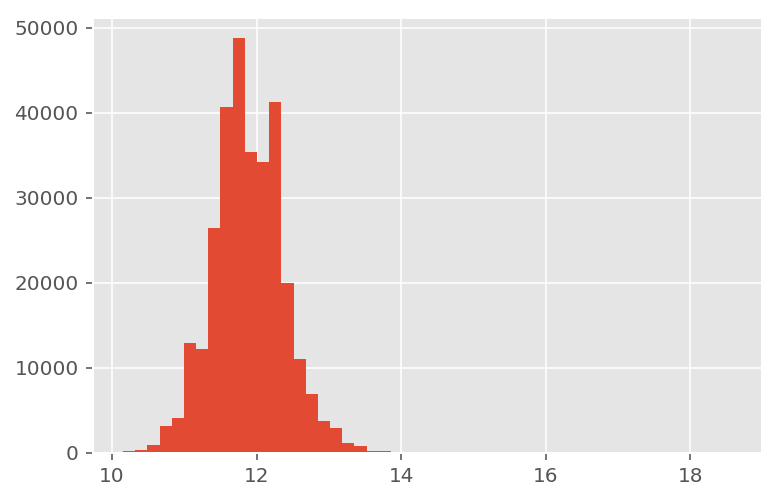

In [38]:
np.log(application_train.AMT_INCOME_TOTAL).hist(bins=50)

In [41]:
temp['log_income_total'] = np.log(temp.AMT_INCOME_TOTAL)

In [42]:
a = temp['log_income_total']
temp['log_income_cut']=pd.cut(
    temp.log_income_total, bins=[0, 11.503,11.899,12.218,18.579],
    labels=["low", "medium-low", "medium", "high"])

In [43]:
temp.log_income_cut.value_counts(1,dropna=False).sort_index()

low           0.207053
medium-low    0.292939
medium        0.214233
high          0.285775
Name: log_income_cut, dtype: float64

In [44]:
df_income_target = pd.crosstab(temp.log_income_cut, temp.TARGET).apply(lambda r:r/r.sum(), axis=0)


In [45]:
df_income_target['1-0']=df_income_target[1]-df_income_target[0]

In [46]:
df_income_target

TARGET,0,1,1-0
log_income_cut,,,
low,0.206752,0.210473,0.003721
medium-low,0.291231,0.312387,0.021155
medium,0.213325,0.224572,0.011247
high,0.288691,0.252568,-0.036123


In [47]:
(df_income_target*100).round(2)

TARGET,0,1,1-0
log_income_cut,,,
low,20.68,21.05,0.37
medium-low,29.12,31.24,2.12
medium,21.33,22.46,1.12
high,28.87,25.26,-3.61


In [48]:
pd.crosstab(temp.log_income_cut, temp.TARGET).apply(lambda r:r/r.sum(), axis=1)

TARGET,0,1
log_income_cut,,
low,0.917938,0.082062
medium-low,0.913912,0.086088
medium,0.915375,0.084625
high,0.928652,0.071348


In [49]:
temp.TARGET.value_counts(1)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

### Amount credit

In [50]:
show_corr('AMT_CREDIT')

,Most negative corr column,Most negative corr value,Most positive corr column,Most positive corr value
0,NAME_CONTRACT_TYPE_Revolving loans,-0.221648,AMT_CREDIT,1.000000
1,FLAG_OWN_CAR_N,-0.116225,AMT_GOODS_PRICE,0.986968
2,REGION_RATING_CLIENT_W_CITY,-0.110915,AMT_ANNUITY,0.770138
3,NAME_EDUCATION_TYPE_Secondary / secondary special,-0.108250,NAME_CONTRACT_TYPE_Cash loans,0.221648
4,REGION_RATING_CLIENT,-0.101776,EXT_SOURCE_1,0.168429
5,NAME_FAMILY_STATUS_Single / not married,-0.096918,AMT_INCOME_TOTAL,0.156870


###  Phone

In [51]:
pd.crosstab(temp.FLAG_PHONE, temp.TARGET).apply(lambda r:r/r.sum(), axis=1)

TARGET,0,1
FLAG_PHONE,,
0,0.915216,0.084784
1,0.929643,0.070357


In [52]:
pd.crosstab(temp.FLAG_CONT_MOBILE, temp.TARGET).apply(lambda r:r/r.sum(), axis=1)

TARGET,0,1
FLAG_CONT_MOBILE,,
0,0.921603,0.078397
1,0.919267,0.080733


In [53]:
temp[(temp.FLAG_CONT_MOBILE==1)&(temp.FLAG_PHONE==1)].TARGET.value_counts()

0    80236
1     6071
Name: TARGET, dtype: int64

In [54]:
pd.crosstab(temp.FLAG_EMP_PHONE, temp.TARGET).apply(lambda r:r/r.sum(), axis=1)

TARGET,0,1
FLAG_EMP_PHONE,,
0,0.945997,0.054003
1,0.913400,0.086600


In [ ]:
docs =  ['FLAG_DOCUMENT_2',  'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [55]:
list(jobs)

['Accountants',
 'Cleaning staff',
 'Cooking staff',
 'Core staff',
 'Drivers',
 'High skill tech staff',
 'Laborers',
 'Low-skill Laborers',
 'Managers',
 'Medicine staff',
 'Private service staff',
 'Sales staff',
 'Security staff']

In [56]:
cols = ['TARGET','DAYS_BIRTH','REGION_RATING_CLIENT_W_CITY','AMT_CREDIT',
        'AMT_INCOME_TOTAL','DAYS_EMPLOYED','EXT_SOURCE_1','EXT_SOURCE_2',
        'EXT_SOURCE_3','OBS_60_CNT_SOCIAL_CIRCLE', 'FLAG_OWN_REALTY',
        'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','WALLSMATERIAL_MODE',
        'CODE_GENDER','OCCUPATION_TYPE','FLAG_OWN_CAR','OWN_CAR_AGE',
        'AMT_ANNUITY','AMT_GOODS_PRICE','FLAG_PHONE','FLAG_EMP_PHONE',
        'FLAG_CONT_MOBILE','FLAG_MOBIL','DAYS_LAST_PHONE_CHANGE']

cols = list(set(cols))

def features_engineer(df, col_list):
    newdf = df[col_list].copy()

    
    # Loan
    newdf['AMT_CREDIT'] = np.log(newdf['AMT_CREDIT'])
    newdf['AMT_ANNUITY'] = np.log(newdf['AMT_ANNUITY'])
    newdf['AMT_GOODS_PRICE'] = np.log(newdf['AMT_GOODS_PRICE'])
    
    # About Age
    newdf["DAYS_BIRTH"] = newdf["DAYS_BIRTH"]/-365
    newdf.loc[newdf["DAYS_EMPLOYED"]>0,'DAYS_EMPLOYED']=1
    
    # binarize income types
    dummies = pd.get_dummies(newdf["NAME_INCOME_TYPE"])
    if 'Maternity leave' in dummies.columns:
        dummies.drop('Maternity leave', axis=1, inplace=True)
    newdf = pd.concat([newdf, dummies], axis=1)
    newdf.drop('NAME_INCOME_TYPE', axis=1, inplace=True)
    
    # Education types
    dummies = pd.get_dummies(newdf["NAME_EDUCATION_TYPE"])
    if 'Academic degree' in dummies.columns:
        dummies.drop('Academic degree', axis=1, inplace=True)
    newdf = pd.concat([newdf, dummies], axis=1)
    newdf.drop('NAME_EDUCATION_TYPE', axis=1, inplace=True)    
    
    # Asset - house
    newdf['FLAG_OWN_REALTY'] = pd.get_dummies(newdf['FLAG_OWN_REALTY'],drop_first=True)
    dummies = pd.get_dummies(newdf["WALLSMATERIAL_MODE"])
    dummies.drop(['Block','Others','Mixed'], axis=1, inplace=True)
    newdf = pd.concat([newdf, dummies], axis=1)
    newdf.drop('WALLSMATERIAL_MODE', axis=1, inplace=True) 
    
    
    # Asset - car
    newdf['FLAG_OWN_CAR'] = pd.get_dummies(newdf['FLAG_OWN_CAR'],drop_first=True)
    newdf['OWN_CAR_AGE_squared'] = newdf['OWN_CAR_AGE']
    newdf['FLAG_OWN_CAR_CAR_AGE']=newdf['FLAG_OWN_CAR']*newdf['OWN_CAR_AGE']
    
    # Phone
    newdf['DAYS_LAST_PHONE_CHANGE']=newdf['DAYS_LAST_PHONE_CHANGE']/-365
    
    # Gender
    dummies = pd.get_dummies(newdf["CODE_GENDER"])
    if 'XNA' in dummies.columns:      
        dummies.drop('XNA', axis=1, inplace=True)
    newdf.drop('CODE_GENDER', axis=1, inplace=True)
    
    # Job types
    dummies = pd.get_dummies(newdf["OCCUPATION_TYPE"])
    newdf = pd.concat([newdf, dummies[jobs]], axis=1)
    newdf.drop('OCCUPATION_TYPE', axis=1, inplace=True) 
    
    # Income 
    newdf['log_income_total'] = np.log(newdf['AMT_INCOME_TOTAL'])
    newdf['log_income_cut']=pd.cut(
    newdf['log_income_total'], bins=[0,11.503,11.899,12.218,18.579],
    labels=["low", "medium-low", "medium", "high"])
    dummies = pd.get_dummies(newdf["log_income_cut"])
    dummies.drop(['low','medium'], axis=1, inplace=True)
    newdf.drop(['log_income_cut','log_income_total'], axis=1, inplace=True) 
    
    # Repayment mutiples
    newdf['loan_income_mutiple'] = newdf['AMT_CREDIT']/newdf['AMT_INCOME_TOTAL']
    newdf['annuity_income'] = newdf['AMT_ANNUITY']/newdf["AMT_INCOME_TOTAL"]
    newdf['goods_price_income'] = newdf['AMT_GOODS_PRICE']/newdf["AMT_INCOME_TOTAL"]
    
    # Documents
    
    
    # Some interaction terms
    newdf['Days_vs_source_1'] = newdf['EXT_SOURCE_1']/newdf['DAYS_BIRTH']
    newdf['Days_vs_employed'] = newdf['DAYS_EMPLOYED']*newdf['DAYS_BIRTH']
    newdf['EXT_SOURCE_2_vs_REGION_RATING_CLIENT_W_CITY'] = newdf['EXT_SOURCE_2']*newdf['REGION_RATING_CLIENT_W_CITY']
    
    return newdf

In [57]:
df_train_2 = features_engineer(application_train,cols)

if 'TARGET' in cols:
    cols_no_target = cols.copy()
    cols_no_target.remove('TARGET')
else:
    cols_no_target=cols.copy()
    
df_test = features_engineer(application_test,cols_no_target)

In [58]:
X = df_train_2.drop('TARGET',axis=1).values
y = df_train_2['TARGET'].values


X_train, X_test, y_train, y_test = train_test_split(X, y)

# imputer all the nan by median or mean
imp = Imputer(strategy='median') 
imp.fit(X_train) 

# transform the test & train data
X_train=imp.transform(X_train)
X_test=imp.transform(X_test)

# rescaling features is important
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (230633, 55)
Testing data shape:  (76878, 55)


In [59]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

accuracies = []
precisions = []
recalls = []
aucs = []

for train_index, test_index in kf.split(X_train):
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_train[train_index], y_train[train_index])
    
#     proba = model.predict_proba(X_train[test_index])[:, 1]
#     y_predict = proba>=0.15   
#     changing the thresholds can change the tpr and fpr
    
    y_predict = model.predict(X_train[test_index])
    y_true = y_train[test_index]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict)
    
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))
    aucs.append(auc(fpr, tpr))
    
    
print("accuracy:", np.average(accuracies))
print("precision:", np.average(precisions))
print("recall:", np.average(recalls))
print("auc:", np.average(aucs))

accuracy: 0.686723072655
precision: 0.159498747717
recall: 0.669778599774
auc: 0.678998456833


to compare:
```
old model:
accuracy: 0.687048266413
precision: 0.159131279008
recall: 0.670711590906
auc: 0.679588691017
```


0.742973658774


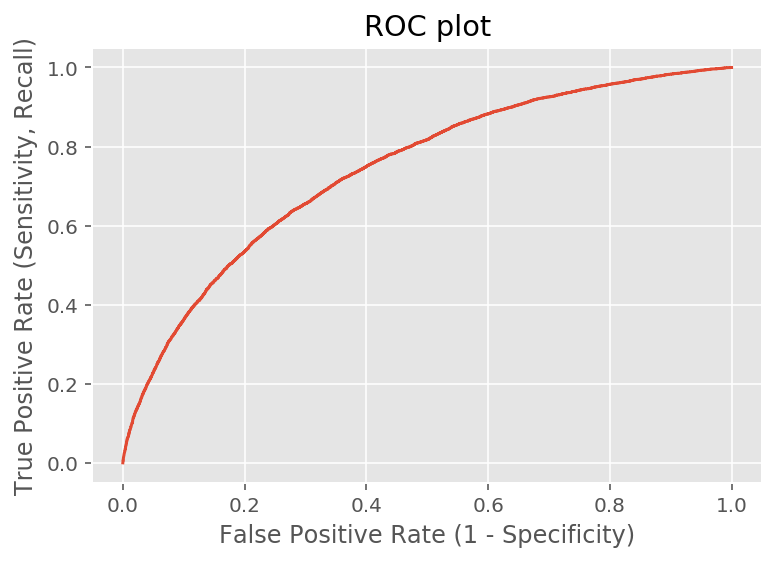

In [60]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
print(auc(fpr, tpr))# old:0.744496536485
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot")
plt.show();

## Submission

In [ ]:
application_train = pd.read_csv('data/application_train.csv.zip') 
application_test = pd.read_csv('data/application_test.csv.zip') 

Last step, retrain model with all the data.

top idea:
obs_30 or obs_60
Amt_credit / income
Fam size vs cnt chidren
own realty
own car
nice to have:
amt_req_redit_buro
housing type

In [ ]:
df_train = features_engineer(df=application_train,col_list=cols)

if 'TARGET' in cols:
    cols_no_target = cols.copy()
    cols_no_target.remove('TARGET')
else:
    cols_no_target=cols.copy()
    
df_test = features_engineer(df=application_test,col_list=cols_no_target)

In [ ]:
print(df_train.shape)
print(df_test.shape)

In [ ]:
X_train = df_train.drop('TARGET',axis=1).values
y_train = df_train['TARGET'].values
X_test = df_test.values

In [ ]:
imp = Imputer(strategy='median') 
imp.fit(X_train) 

# transform the test & train data
X_train=imp.transform(X_train)
X_test=imp.transform(X_test)


scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

In [ ]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
probabilities = model.predict_proba(X_test)[:, 1]

In [ ]:
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = probabilities
submit.head()

In [ ]:
submit.to_csv('logistic_baseline5.csv', index = False)

Your submission scored 0.733, which is an improvement of your previous score of 0.726. 

top idea:
obs_30 or obs_60
Amt_credit / income
Fam size vs cnt chidren
own realty
own car
nice to have:
amt_req_redit_buro
housing type
